In [1]:
import math

def sim_config_init(game_type= 'fear', lgr=(10,1.1,0.5), num_bots=20, game_length=1000, decimals = 2, #basic setup
                    initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
                    initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
                    move_percent = 0.1, 
                    payoff_multiplier=1, payoff_deduction=40,
                    trembling_dist='uniform', trembling_range=(1,2),  
                    leaving_function='distance',
                     outlier_index_set=[1,3],  ):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    ##basic setup## 
    # game type: could be 'fear', 'greed'
    config['game_type'] = game_type

    # lambda/gamma/rho params
    config['lambda'] = lgr[0]
    config['gamma'] = lgr[1]
    config['rho'] = lgr[2]
    
    # based on gamma and rho, override game type
    if (config['game_type'] != 'other') and (config['gamma'] >= (config['rho'] + 4/3)):
        config['game_type'] = 'greed'
    elif (config['game_type'] != 'other') and (config['gamma'] <= (config['rho'] + 2/3)):
        config['game_type'] = 'fear'
        
    # decimals
    config['decimals'] = decimals

    # NE support 
    if config['game_type'] == 'fear':
        config['NE_support_min'] = max(0, round((config['lambda'] - math.sqrt(1+config['lambda']**2) * math.sqrt(1-(16*(1+config['rho'])*(config['gamma']-1))/((config['gamma'] +3*config['rho'])*(3*config['gamma'] +config['rho'])))),config['decimals']))
        config['NE_support_max'] = config['lambda']
    elif config['game_type'] == 'greed':
        config['NE_support_min'] = config['lambda']
        config['NE_support_max'] = round(config['lambda'] + math.sqrt(1+config['lambda']**2)/(math.sqrt(1+16*config['rho']*config['gamma']/((3*config['gamma']-3*config['rho']-2)*(config['gamma']-config['rho']+2)))), config['decimals'])


    # number of bots
    config['num_bots'] = num_bots
 
    # game length
    config['game_length'] = game_length
    

    
    ##initialization## -- how does the game start
    # initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
    config['initialization_dist'] = initialization_dist
 
    # initialization range: if 'uniform' set the range; if 'normal', set mean and std
    config['initialization_range'] = initialization_range    
    
    
    ##landscape bound
    # x bound
    if config['game_type'] == 'fear':
        config['xmin'] = max(0 , config['NE_support_min']-2)
        config['xmax'] = config['NE_support_max'] + 3
    elif config['game_type'] == 'greed':
        config['xmin'] = max(0 , config['NE_support_min']-3)
        config['xmax'] = config['NE_support_max'] + 2
 

    # manipulate simulation similar to human experiment
    # landscape multiplys a number
    config['payoff_multiplier'] = payoff_multiplier
    
    # shifts landscape down by a value
    config['payoff_deduction'] = payoff_deduction

    
    ## trembling (noise)
    # trembling distribution: could be 'normal', 'uniform', 'triangular'
    config['trembling_dist'] = trembling_dist
    
    # trembling range
    config['trembling_range'] = trembling_range
    
    #leaving function type: distance; endogenous; replicator
    config['leaving_function'] = leaving_function    
    
    
    # move percentage
    config['move_percent'] = move_percent
    

    #index of outliers
    config['outlier_index_set'] = outlier_index_set   
    

    

    
    return config

In [2]:
import random
import numpy as np
import pandas as pd

def initialize_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies 
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # these calculations are inexact because we have a finite number of players

    game_type = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    NE_support_min = config['NE_support_min']
    NE_support_max = config['NE_support_max']
    initialization = config['initialization_dist']
    decimals = config['decimals']

    strategies = []

    ## initialization starts from NE: theoritical prediction
    if initialization == 'NE':
        if game_type == 'fear':
            NE_support_x = np.round(np.arange(NE_support_min, NE_support_max, 1/(10**decimals)), decimals)
            # according to theory
            NE_support_cdf = gam - rho + np.sqrt(np.round((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * NE_support_x - NE_support_x ** 2),decimals))
            NE_support_cdf = np.nan_to_num(NE_support_cdf) #convert nan to 0
            NE_support_cdf = NE_support_cdf/2
            cdf_ind = 0
            for i in range(num_bots):
            # cdf_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
                if (i+1)/num_bots <= NE_support_cdf[cdf_ind]:
                    strategies.append(NE_support_x[cdf_ind])
                else:
                    while cdf_ind < len(NE_support_cdf) - 1 and (i+1)/num_bots > NE_support_cdf[cdf_ind]:
                        cdf_ind = cdf_ind + 1
                    # there are some rounding issues when we reach the end of the cdf
                    # if we reach the end (for the last few players), just use the last value
                    if cdf_ind >= len(NE_support_cdf):
                        strategies.append(NE_support_x[len(NE_support_cdf)])
                    else:
                        strategies.append(NE_support_x[cdf_ind])
            strategies = np.array(strategies)
                        
        elif game_type == 'greed':
            NE_support_x = np.round(np.arange(NE_support_min, NE_support_max, 1/(10**decimals)), decimals)
            NE_support_cdf = gam - rho - np.sqrt(np.round((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * NE_support_x - NE_support_x ** 2),decimals))
            NE_support_cdf = np.nan_to_num(NE_support_cdf) #convert nan to 0
            NE_support_cdf = NE_support_cdf / 2
            cdf_ind = len(NE_support_cdf) - 1
            i = num_bots
            while i > 0:
                # cdf_ind is the index in the cdf to compare to
                # we decrement it until it is less than or equal to the percentage of players set so far
                if (i-1)/num_bots >= NE_support_cdf[cdf_ind]:
                    strategies.append(NE_support_x[cdf_ind])
                else:
                    while cdf_ind > 0 and (i-1)/num_bots < NE_support_cdf[cdf_ind]:
                        cdf_ind = cdf_ind - 1
                    # there are some rounding issues when we reach the end of the cdf
                    # if we reach the end (for the last few players), just use the last value
                    if cdf_ind == 0:
                        strategies.append(NE_support_x[0])
                    else:
                        strategies.append(NE_support_x[cdf_ind])
                i = i - 1
            strategies = np.array(strategies)
                
    ## initialization starts from NE support: uniform distrubution within NE support         
    elif initialization == 'NE_support':
        strategies = np.random.uniform(NE_support_min, NE_support_max, num_bots)
            
    elif initialization == 'uniform': 
        initialization_range_min = config['initialization_range'][0]
        initialization_range_max = config['initialization_range'][1]
        strategies = np.random.uniform(initialization_range_min, initialization_range_max, num_bots)
        
    elif initialization == 'normal': 
        initialization_range_mean = config['initialization_range'][0]
        initialization_range_std = config['initialization_range'][1]
        strategies = np.random.normal(initialization_range_mean, initialization_range_std, num_bots)
        
    strategies = np.round(strategies, decimals)
    strategies = np.sort(strategies)
            
    initial_strategies = strategies.copy()

    return strategies, initial_strategies



#########################
def get_position(n, strategies, config):
    '''

    :param n: float, timing/location n
    :param strategies: array, current strategies
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    if config['game_type'] == 'fear':
        pos = len([strat for strat in strategies if n > strat]) + 1
    elif config['game_type'] == 'greed':
        pos = len([strat for strat in strategies if n > strat])
    return pos

# Returns ties at timing n
def get_tie(n, strategies, config):
    '''
    :param n: float, timing n
    :param strategies: array, current strategies
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    decimals = config['decimals'] 
    # this is only here to fix rounding comparison issues
    n = round(n,decimals)

    tie = 0
    # compare to strategies to calculate position
    tie = len([strat for strat in strategies if n == round(strat, decimals)])
    return tie



def calculate_payoff(config, strategies):
    '''
    calculate payoff at every x at period 0
    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    decimals = config['decimals']
    payoff_multiplier = config['payoff_multiplier']
    payoff_deduction = config['payoff_deduction']
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 1/10**decimals),decimals)
    positions = []
    ties = []
    # set up values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, strategies, config))
        ties.append(get_tie(val, strategies, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
            quantile.append(positions[i]/len(strategies))
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
            
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']    
        
    y = ux * vy*payoff_multiplier - payoff_deduction
    strategies_y = []
    bubble = []
    # calculate bubble positions
    for strat in strategies:
        strat = round(strat,decimals)
        indice = np.where(x == strat)[0] #reduce running time b 90%
        bubble.append(y[indice][0])
#         print(strat, indice, y[indice])
#         bubble.append(get_y(strat, strategies, config))
    return x, y, quantile, bubble


# Loops through all players and moves them if they are ready to move
def update_strategies_unpurified(x, y, strategies, bubble, config):
    '''
    :param x: numpy array, array of possible x
    :param y: numpy array, payoff array w.r.t each element in x
    :param strategies: list, list containing previous strategies of each player
    :param config: dict, dictionary containing simulation parameters
    :return: strategies: list, list containing updated strategies of each player
    '''
    trembling_range = config['trembling_range']
    trembling_dist = config['trembling_dist']
    move_size = round(config['move_percent'] *config['num_bots'])
    static_strategies = strategies.copy()
    outlier_index_set = config['outlier_index_set']
    NE_support_min = config['NE_support_min']
    NE_support_max = config['NE_support_max']
    xmin = config['xmin']
    xmax = config['xmax']
    game_type = config['game_type']
    
    best_possible = max(y)
    players_index = list(range(len(strategies)))
    
    ###random
    # random choose n players to move
    if config['leaving_function'] == 'random':
        selected_player_index = random.sample(players_index, move_size)
    
    # jump frequencies proportional to regret
    elif config['leaving_function'] == 'distance_proportional':
        distances_from_best_payoff = abs(bubble-best_possible)
        distances_from_best_payoff = np.round(distances_from_best_payoff, decimals=2)
        n=0
        selected_player_index = set([])
        while n < move_size:
            chosen_one = random.choices(players_index, weights=distances_from_best_payoff,k=1)
            selected_player_index.update(chosen_one)
            index = players_index.index(chosen_one[0])
            del players_index[index]
            distances_from_best_payoff = np.delete(distances_from_best_payoff, index)
            n+=1
            sum_weights = math.fsum(distances_from_best_payoff)
            if sum_weights == 0:
                break
        if len(selected_player_index) != move_size:
            remaining = random.sample(players_index,k=move_size-n)
            selected_player_index.update(remaining)

    # players with the most n gain move
    elif config['leaving_function'] == 'distance_most_gain':
        distances_from_best_payoff = abs(bubble-best_possible)
        # Get indices of the first n largest values
        selected_player_index = np.argsort(-distances_from_best_payoff)[:move_size]
        
            
    ###arriving function

    for i in selected_player_index:
    # find best payoff index
        index = i  
        indices = [k for k, j in enumerate(y) if j == best_possible]
        best_choice = random.choice(indices)
        best_choice = x[best_choice]                


        if best_choice == static_strategies[index]:    
            strategies[i] = best_choice
#                 strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)
        else:
            if trembling_dist == 'uniform':
                strategies[i] = best_choice + np.random.uniform(trembling_range[0], trembling_range[1], 1)[0]
            elif trembling_dist == 'normal':
                strategies[i] = best_choice + np.random.normal(trembling_range[0], trembling_range[1], 1)[0]
            elif trembling_dist == 'triangular':
                strategies[i] = best_choice + np.random.triangular(-trembling_range[1],trembling_range[0],trembling_range[1], 1)
            elif trembling_dist == 'None':
                strategies[i] = best_choice
        
    strategies = np.round(strategies, 2)


#                 if game_type == 'fear':
# #                     strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0.3), 2)*config['uneven']
#                     strategies[i] = best_choice + np.random.normal(0, trembling, 1)[0]
#                 elif game_type == 'greed':
# #                     strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2) + round((random.random() * 0.3 - 0), 2)*config['uneven']
#                    strategies[i] = best_choice + np.random.normal(0, trembling, 1)[0]
#         if i in outlier_index_set:
#             strategies[i] = round(random.random() * (cdfmax - cdfmin) + cdfmin, 2)
#         print(strategies)
###########################################        
  
    
    return strategies, selected_player_index


In [11]:
from datetime import datetime
from PIL import Image
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib notebook


main_folder = 'one_shot_NE/'
# rho_values = [0.5, 1, 1.5, 2,2.5, 3,3.5, 4, 5, 6, 7, 8, 10, 20, 50, 100, 500, 1000]
rho_values = [0.5, 1, 1.5, 2,2.5, 3,3.5, 4,4.5, 5, 6, 7, 8, 10, 20]
gam_minus_rho = np.array(
   [ -4, -3, -2, -1, 0, #fear w/o rush
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, #fear w/ rush
    0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: fear
    0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, #two eqm: greed
    1.4, 1.5, 1.6, 1.7, 1.8, 1.9, #greed w/ rush
    2, 3, 4, 5, 6] #greed w/o rush
)
game_types = ['fear']*18+['greed']*18

#dataframe cols
game_type_list = []
lam_list = []
rho_list = []
gam_list = []
gam_minus_rho_list = []
rush_size_list = []
theory_rush_size_list = []
rush_location_list = []
theory_rush_location_list = []
avg_payoff_list = []
theory_payoff_list = []
NE_support_min_list = []
NE_support_max_list = []

start=datetime.now()
for rho_value in rho_values:
    gam_values = rho_value + gam_minus_rho
    
    for ind_value in range(len(gam_values)):
        # gamma should be greater than 1
        if gam_values[ind_value]<=1:     
            #log data
            game_type_list.append(game_types[ind_value])
            lam_list.append(10)
            gam_list.append(gam_values[ind_value])
            rho_list.append(rho_value)
            gam_minus_rho_list.append(gam_values[ind_value]-rho_value)
            rush_size_list.append(np.nan)
            rush_location_list.append(np.nan)
            avg_payoff_list.append(np.nan)
            NE_support_min_list.append(np.nan)
            NE_support_max_list.append(np.nan)
            theory_rush_size_list.append(np.nan)
            theory_rush_location_list.append(np.nan)
            theory_payoff_list.append(np.nan)
        else:
            sim_config = sim_config_init(
                game_type= game_types[ind_value], 
                lgr=(20,gam_values[ind_value],rho_value), 
                num_bots=200, 
                game_length=0, 
                decimals = 3,
                initialization_dist = 'NE', #initialization, can be 'NE', 'NE_support', 'uniform', 'normal'
                initialization_range = (1,2), # if 'uniform' set the range; if 'normal', set mean and std
                move_percent = 0.2, 
                trembling_dist='normal', #normal or None or uniform or triangular
                trembling_range=(0,0.03), 
                leaving_function='random', #random or distance_proportional, distance_most_gain
                outlier_index_set=[],  
                payoff_multiplier=1, 
                payoff_deduction=0,
            )

            NE_support_min = sim_config['NE_support_min']
            NE_support_max = sim_config['NE_support_max']

          # Simulate players' initial strategies and payoffs
            strategies,initial_strategies = initialize_strategies(sim_config)
            x, y, quantile, bubble = calculate_payoff(sim_config, strategies)

            if sim_config['game_type'] == 'fear':
                rush_location = strategies[0]
                theory_rush_location = NE_support_min
                theory_payoff = (1+1/sim_config['rho'])*(1-1/sim_config['gamma'])*(1+sim_config['lambda']**2)
                if sim_config['gamma']<= sim_config['rho']:
                    theory_rush_size = 0
                else:
                    theory_rush_size = 0.75*(sim_config['gamma']-sim_config['rho'])
            elif sim_config['game_type'] == 'greed':
                rush_location = strategies[-1]
                theory_rush_location = NE_support_max
                theory_payoff = 1+sim_config['lambda']**2
                if sim_config['gamma']>= sim_config['rho'] + 2:
                    theory_rush_size = 0
                else:
                    theory_rush_size = 1-(0.75*(sim_config['gamma']-sim_config['rho']) - 0.5)

            rush_size = len(np.where(strategies==rush_location)[0])/sim_config['num_bots']
            avg_payoff = np.array(bubble).mean()  

            #log data
            game_type_list.append(sim_config['game_type'])
            lam_list.append(sim_config['lambda'])
            gam_list.append(sim_config['gamma'])
            rho_list.append(sim_config['rho'])
            gam_minus_rho_list.append(sim_config['gamma']-sim_config['rho'])
            rush_size_list.append(rush_size)
            rush_location_list.append(rush_location)
            avg_payoff_list.append(avg_payoff)
            NE_support_min_list.append(NE_support_min)
            NE_support_max_list.append(NE_support_max)
            theory_rush_size_list.append(theory_rush_size)
            theory_rush_location_list.append(theory_rush_location)
            theory_payoff_list.append(theory_payoff)

#             print('sim ', ind_value)
        
print('simulation spent time: {}'.format(datetime.now()-start))        
d = {'game_type': game_type_list, 'lam': lam_list, 'gam': gam_list, 'rho': rho_list, 
     'gam_minus_rho':gam_minus_rho_list, 'rush_size':rush_size_list,'theory_rush_size':theory_rush_size_list, 
     'rush_location':rush_location_list, 'theory_rush_location':theory_rush_location_list, 
     'avg_payoff':avg_payoff_list,'theory_payoff':theory_payoff_list, 'NE_support_min':NE_support_min_list,'NE_support_max':NE_support_max_list,}
df = pd.DataFrame(data=d)    

# Save the DataFrame to a CSV file
df.to_csv('sim_'+str(sim_config['num_bots'])+ '_lam'+str(sim_config['lambda'])+'bots_one_shot.csv', index=False)

/var/folders/15/djmbdtz95_34fcrr8nrcvk_40000gn/T/ipykernel_8393/3573317554.py:53: RuntimeWarning: invalid value encountered in sqrt
  NE_support_cdf = gam - rho - np.sqrt(np.round((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * NE_support_x - NE_support_x ** 2),decimals))
/var/folders/15/djmbdtz95_34fcrr8nrcvk_40000gn/T/ipykernel_8393/3573317554.py:31: RuntimeWarning: invalid value encountered in sqrt
  NE_support_cdf = gam - rho + np.sqrt(np.round((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * NE_support_x - NE_support_x ** 2),decimals))


simulation spent time: 0:29:48.909648


In [2]:
cd './one_shot_NE/lam20'

/Users/weinan/Documents/GitHub/oTreeProjects/TimingGames2024/one_shot_NE/lam20


In [3]:
import pandas as pd
df = pd.read_csv('sim_200_lam20bots_one_shot.csv')
df_copy = df.copy()

In [4]:
df_copy['rho'] = round(df_copy['rho'],1)
df_copy['gam_minus_rho'] = round(df_copy['gam_minus_rho'],1)
df_copy['rho'] = df_copy['rho'].astype('category')
df_copy['gam_minus_rho'] = df_copy['gam_minus_rho'].astype('category')

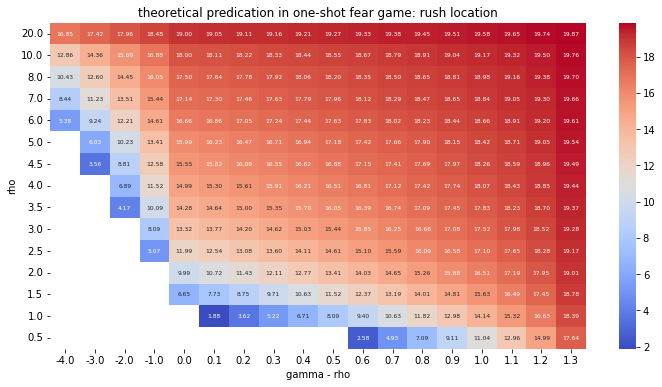

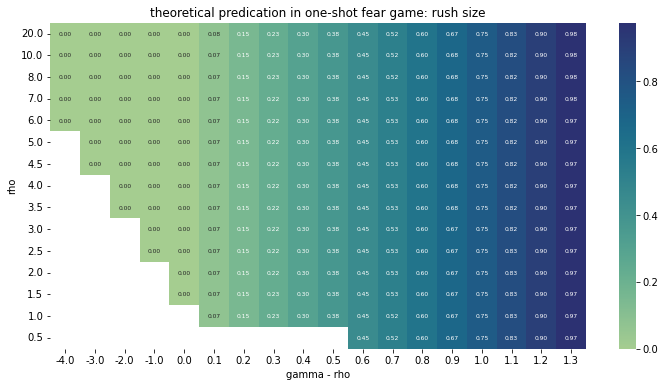

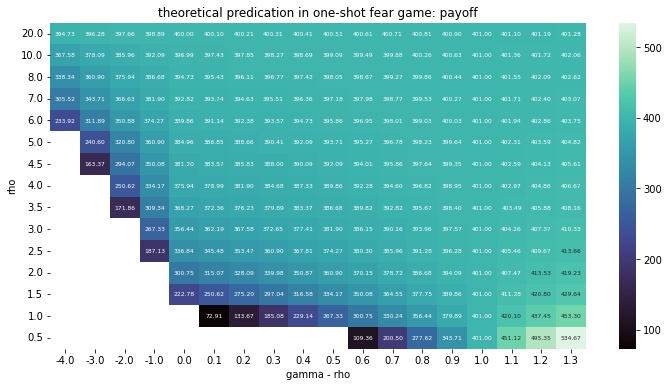

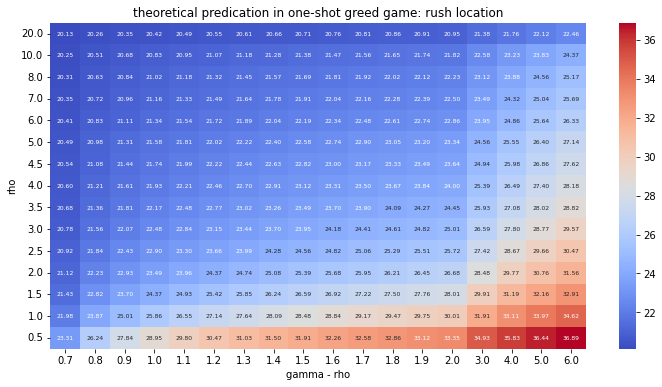

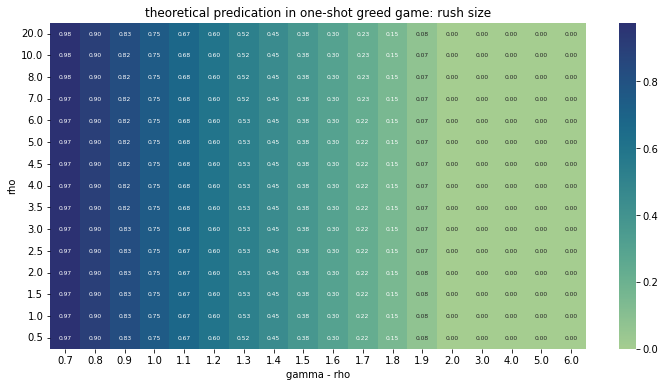

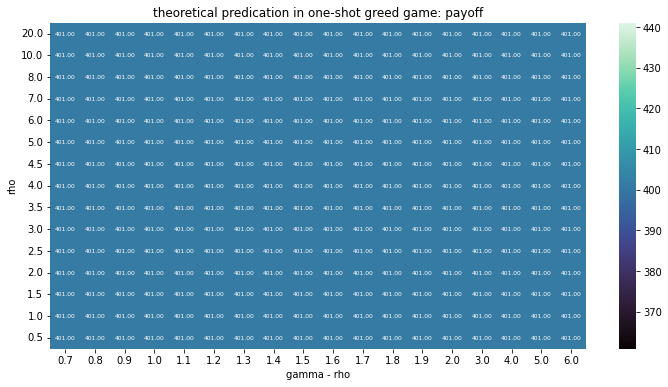

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
df_fear = df_copy[df_copy['game_type']=='fear']
df_greed = df_copy[df_copy['game_type']=='greed']

#############fear##################
###### rush location ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_fear, values='theory_rush_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot fear game: rush location')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('fear_one_shot_rush_location.png', bbox_inches='tight')


###### rush size ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_fear, values='theory_rush_size', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="crest")
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot fear game: rush size')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('fear_one_shot_rush_size.png', bbox_inches='tight')

###### payoff ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_fear, values='theory_payoff', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="mako")
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot fear game: payoff')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('fear_one_shot_payoff.png', bbox_inches='tight')



#####################################
#############greed##################
###### rush location ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_greed, values='theory_rush_location', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap='coolwarm')
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot greed game: rush location')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('greed_one_shot_rush_location.png', bbox_inches='tight')


###### rush size ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_greed, values='theory_rush_size', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="crest")
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot greed game: rush size')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('greed_one_shot_rush_size.png', bbox_inches='tight')

###### payoff ######
# Create a pivot table with mean
pivot_table = pd.pivot_table(df_greed, values='theory_payoff', index='rho', columns='gam_minus_rho')
# Sort the pivot table index from lowest to highest
sorted_pivot_table = pivot_table.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sorted_pivot_table, annot=True, fmt=".2f", annot_kws={"size": 6}, cmap="mako")
# plt.axvline(x=0.3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.title('theoretical predication in one-shot greed game: payoff')
plt.ylabel('rho')
plt.xlabel('gamma - rho')
plt.show()
# plt.savefig('greed_one_shot_payoff.png', bbox_inches='tight')


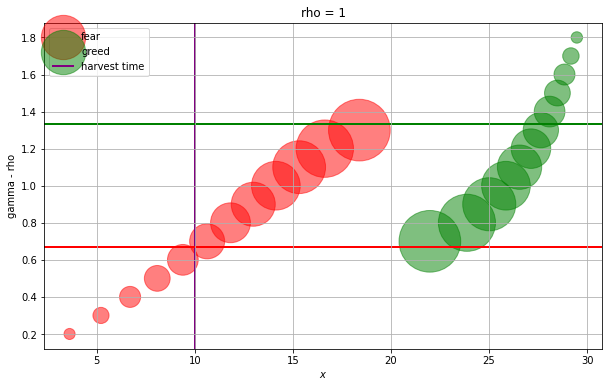

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
rho_value = 1
df_rush = df[(df['gam_minus_rho']>0.1)&(df['gam_minus_rho']<1.9)&(df['rho']==rho_value)]
df_rush_fear = df_rush[df_rush['game_type']=='fear']
df_rush_greed = df_rush[df_rush['game_type']=='greed']
plt.scatter(x = df_rush_fear['rush_location'],
            y= df_rush_fear['gam_minus_rho'],
            s=(df_rush_fear['rush_size'] * 100)**1.8,
            alpha=0.5,
            color='r', label='fear')
plt.scatter(x = df_rush_greed['rush_location'],
            y= df_rush_greed['gam_minus_rho'],
            s=(df_rush_greed['rush_size'] * 100)**1.8,
            alpha=0.5,
            color='g', label='greed')
plt.axvline(x=10, color='purple', linestyle='-',linewidth=2, label='harvest time', zorder=1)
plt.axhline(y=2/3, color='r', linestyle='-',linewidth=2, zorder=1)
plt.axhline(y=4/3, color='g', linestyle='-',linewidth=2, zorder=1)
plt.ylabel('gamma - rho')
plt.xlabel('$x$')
plt.title('rho = '+ str(rho_value))
plt.grid()
plt.legend()
plt.show()
# plt.savefig('rush_size_rho' + str(rho_value) +'.png', bbox_inches='tight')